As of May 18th, I fixed a couple of cells that had n/a and should be empty to be properly read.

As of August 4th, whenever TFA changes for a given pair, I'm taking the most common one as A.

Notice that I am calculating synergy for each experiment, and then averaging over experiments.
So if for a given experiment there is not a measure for the combination at 1X1X and each individual TF at 2X then I cannot use that information.

Update the barplot figure without the cMyc outlier.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import itertools
import os
import glob
import matplotlib as mpl
mpl.rcParams["font.size"]=12
import re

In [2]:
f0='./data/RMCmod20190212transf_KC_minCMV full matrix_ALL.csv'
f7v1='./data/RMC_20181202_KC_M796(minCMV)_combo_tot 20ng_ALL_IRFPnorm.csv'
#f7v2='./data/20181202_KC_M796(minCMV)_combo WT 7X_tot 20ng/RMC_20181202_KC_M796(minCMV)_combo_tot 20ng_ALL_v2.csv'
f5='./data/RMC_20181209_KC_M796(minCMV)_combo WT 5X_tot 20ng_ALL_IRFPnorm.csv'
fa='./data/RMC_20190120_KC_M796 (minCMV)_combo_tot 20ng_ALL.csv'
fb='./data/RMC_20190127_KC_M796 (minCMV)_HSF1 HSF1m_ALL.csv'
dflist=[]
names=['activator1','affinity1','activator2','affinity2','GFPfa1','GFPfa2','GFPfa3']
allfs=[f0,f7v1,f5,fa,fb]
subset_df_tojoin=[]
namesdf=["all","WT-7","WT-5","WT-5-7","Hm"]
for fnum,f in enumerate(allfs):
    df=pd.read_csv(f)
    print(f)
    print(df.columns)
    for name in names:
        if not name in df.columns:
            print("*********missing", name)
            
    dflist.append(df)
    subdf=df[names].copy()
    subdf['name']=namesdf[fnum]
    subset_df_tojoin.append(subdf)
alldfsj=pd.concat(subset_df_tojoin)


./data/RMCmod20190212transf_KC_minCMV full matrix_ALL.csv
Index(['ID', 'activator1', 'affinity1', 'activator2', 'affinity2', 'ID2',
       'PCR tube', '#1', '#2', '#3', '#5', 'GFPfluorescence1',
       'GFPfluorescence2', 'GFPfluorescence3', '194.0666667', 'GFPfa1',
       'GFPfa2', 'GFPfa3'],
      dtype='object')
./data/RMC_20181202_KC_M796(minCMV)_combo_tot 20ng_ALL_IRFPnorm.csv
Index(['Unnamed: 0', 'activator1', 'affinity1', 'activator2', 'affinity2',
       '#1', '#2', '#3', '#4', '#5', 'geometricmeanGFP1', 'geometricmeanGFP2',
       'geometricmeanGFP3', 'backgroundpart', 'background', 'GFPfa1', 'GFPfa2',
       'GFPfa3', 'geometricmeanIRFP1', 'geometricmeanIRFP2',
       'geometricmeanIRFP3', 'avg1', 'avg2', 'avg3', 'ratio (GFP/IRFP)1',
       'ratio (GFP/IRFP)2', 'ratio (GFP/IRFP)3', '0.00527336', 'nFC1', 'nFC2',
       'nFC3'],
      dtype='object')
./data/RMC_20181209_KC_M796(minCMV)_combo WT 5X_tot 20ng_ALL_IRFPnorm.csv
Index(['Unnamed: 0', 'activator1', 'affinity1', 'activa

In [3]:
#Compute a dataframe where each row is a pair, and each column has all the info:

TFnames=('cMyc', 'SP1', 'HSF1m', 'HSF1', 'BRD4', 'empty')
affinities=['ZF(WT)','ZF(5X)','ZF(7X)']
cGFP=['GFPfa1','GFPfa2','GFPfa3']

#df=alldfsj
allrows=[]

for n1 in range(len(TFnames)):
    for n2 in range(n1,len(TFnames)):
        #TF1,TF2=TFcombi.split('-')
        TF1=TFnames[n1]
        TF2=TFnames[n2]
        for af1 in affinities:
            for af2 in affinities:
                for df_name in alldfsj.groupby("name"):
                    name,df=df_name
                    combi1=df[(df['activator1']==TF1)&(df['activator2']==TF2)&(df['affinity1']==af1)&(df['affinity2']==af2)] #[cGFP]
                    combi2=df[(df['activator1']==TF2)&(df['activator2']==TF1)&(df['affinity1']==af2)&(df['affinity2']==af1)] #[cGFP]

                    found=True
                    if len(combi1)>0 and len(combi2)>0:
                        subdf=pd.concat([combi1,combi2])
                    elif len(combi1)>0:
                        subdf=combi1
                    elif len(combi2)>0:
                        subdf=combi2
                    else:
                        found=False
                        #if name=="Hm":
                        #    print("not found",name, TF1, af1, TF2, af2)

                    if found:
                        #Notice that for "Hm", the measurements for the 1 TF at 2X concentration are missing and so these are not considered
                        #reference values, with only TF1 or TF2 and a given affinity
                        ref1=df[(df['activator1']==TF1)&(df['activator2']==TF1)&(df['affinity1']==af1)&(df['affinity2']==af1)] 
                        ref2=df[(df['activator1']==TF2)&(df['activator2']==TF2)&(df['affinity1']==af2)&(df['affinity2']==af2)] 
                        if len(ref1)>0 and len(ref2)>0: #need to make sure both references exist
                            combival=np.nanmean(subdf[cGFP].values)
                            r1val=np.nanmean(ref1[cGFP].values)
                            r2val=np.nanmean(ref2[cGFP].values)

                            if r1val>r2val:
                                SAB=np.log2(combival/r1val)
                                SBA=np.log2(combival/r2val)
                                TFA=TF1
                            else:
                                SAB=np.log2(combival/r2val)
                                SBA=np.log2(combival/r1val)
                                TFA=TF2
                            if np.isnan(SAB) or np.isnan(SBA):
                                print("NAN!!",SAB,SBA,combival,r1val,r2val,np.log2(combival/r1val),np.log2(combival/r2val))

                            allrows.append([TF1,TF2,af1,af2,SAB,SBA,TFA,name,combival,r1val,r2val])
            
                    


In [4]:
dfsyn=pd.DataFrame(data=np.vstack(allrows),columns=['TF1','TF2','af1','af2','SAB','SBA','TFA','name',"fcGFPAB","fcGFP1","fcGFP2"])

In [5]:

from IPython.display import display

In [6]:
print("conditions where TFA is not always the same:")
for df_ in dfsyn.groupby(["TF1","TF2","af1","af2"]):
    TFAs=df_[1]["TFA"].values
    TFAsu,indices,count=np.unique(TFAs,return_index=True,return_counts=True)
    if len(TFAsu)>1:
        #print(df_[1])
        display(df_[1])
        if True:
            argmax=np.argmax(count)
            mostcommon=TFAsu[argmax]
            print(count, argmax,mostcommon)
            #swap SAB and SBA:
            indices=df_[1].index
            for idx in indices:
                originalrow=dfsyn.iloc[idx]
                if originalrow["TFA"]!=mostcommon:
                    SAB=originalrow["SAB"]
                    SBA=originalrow["SBA"]
                    dfsyn.loc[idx,"SAB"]=SBA
                    dfsyn.loc[idx,"SBA"]=SAB
                    dfsyn.loc[idx,"TFA"]=mostcommon+"(sw)"
                #print(dfsyn.iloc[idx])
            #print(indices)
    #print(df_[1])

conditions where TFA is not always the same:


,TF1,TF2,af1,af2,SAB,SBA,TFA,name,fcGFPAB,fcGFP1,fcGFP2
230,HSF1m,HSF1,ZF(5X),ZF(WT),-0.03684441703248311,-0.030323080469957003,HSF1m,Hm,3.2435197818333337,3.327421555333333,3.3124147339999994
231,HSF1m,HSF1,ZF(5X),ZF(WT),0.32840537044266943,0.400454839389564,HSF1,all,4.167000000000001,3.157,3.3186666666666667


[1 1] 0 HSF1


,TF1,TF2,af1,af2,SAB,SBA,TFA,name,fcGFPAB,fcGFP1,fcGFP2
240,HSF1m,HSF1,ZF(7X),ZF(7X),0.007292492473955358,0.01707351340831111,HSF1m,Hm,2.435197817166667,2.4229195089999997,2.406548431
241,HSF1m,HSF1,ZF(7X),ZF(7X),-0.0007808904253706932,0.053306625082149416,HSF1,WT-7,2.839354343,2.7363566489999998,2.8408916219999996
242,HSF1m,HSF1,ZF(7X),ZF(7X),0.18811699911869761,0.2827453591947372,HSF1,all,3.2720000000000002,2.689666666666666,2.872


[2 1] 0 HSF1


,TF1,TF2,af1,af2,SAB,SBA,TFA,name,fcGFPAB,fcGFP1,fcGFP2
228,HSF1m,HSF1,ZF(WT),ZF(7X),-0.08221584031230092,0.146471987646985,HSF1m,Hm,2.6637107778333333,2.819918144666667,2.406548431
229,HSF1m,HSF1,ZF(WT),ZF(7X),0.1396938506497405,0.18891527657091922,HSF1,all,3.164,2.7756666666666665,2.872


[1 1] 0 HSF1


,TF1,TF2,af1,af2,SAB,SBA,TFA,name,fcGFPAB,fcGFP1,fcGFP2
159,SP1,HSF1,ZF(7X),ZF(7X),-0.22533970520584087,-0.008823850190159957,HSF1,WT-5-7,2.383428107333333,2.3980503653333334,2.786352558666666
160,SP1,HSF1,ZF(7X),ZF(7X),-0.015122728002005705,0.03851523553334542,SP1,WT-7,2.917755572666666,2.948501153,2.8408916219999996
161,SP1,HSF1,ZF(7X),ZF(7X),-0.14513341103548427,-0.1339580770780365,SP1,all,2.6173333333333333,2.8943333333333334,2.872


[1 2] 1 SP1


,TF1,TF2,af1,af2,SAB,SBA,TFA,name,fcGFPAB,fcGFP1,fcGFP2
108,cMyc,empty,ZF(7X),ZF(7X),-0.15538740338112472,-0.05939292861800472,empty,WT-5-7,1.314378554,1.3696181966666667,1.463850528
109,cMyc,empty,ZF(7X),ZF(7X),0.061805284849481716,0.1554545187467739,empty,WT-7,1.4296694853333332,1.2836279786666667,1.369715603333333
110,cMyc,empty,ZF(7X),ZF(7X),-0.028928267654280963,0.22685747044186932,cMyc,all,1.654,1.6875,1.4133333333333333


[1 2] 1 empty


,TF1,TF2,af1,af2,SAB,SBA,TFA,name,fcGFPAB,fcGFP1,fcGFP2
105,cMyc,empty,ZF(7X),ZF(WT),-0.03431065485785774,-0.020684154417647406,empty,WT-5-7,1.3501218520000002,1.3696181966666667,1.3826157593333335
106,cMyc,empty,ZF(7X),ZF(WT),-0.060973142782513916,0.3933024957306846,cMyc,all,1.6176666666666666,1.6875,1.2316666666666667


[1 1] 0 cMyc


,TF1,TF2,af1,af2,SAB,SBA,TFA,name,fcGFPAB,fcGFP1,fcGFP2
91,cMyc,empty,ZF(WT),ZF(WT),0.06473270178735234,0.6887104260652069,empty,WT-5,1.368715084,0.8491620109999999,1.3086592176666667
92,cMyc,empty,ZF(WT),ZF(WT),-0.36402992762219966,0.04506180821385113,cMyc,WT-5-7,1.4264825346666665,1.8359057676666666,1.3826157593333335
93,cMyc,empty,ZF(WT),ZF(WT),-0.2503802860989836,0.17415312513971712,cMyc,WT-7,1.3789392776666667,1.6402767106666667,1.2221368176666667
94,cMyc,empty,ZF(WT),ZF(WT),-0.29555787320780097,0.3516834065289455,cMyc,all,1.5716666666666665,1.929,1.2316666666666667


[3 1] 0 cMyc


In [7]:
for df_ in dfsyn.groupby(["TF1","TF2","af1","af2"]):
    TFAs=df_[1]["TFA"].values
    TFAsu,indices,count=np.unique(TFAs,return_index=True,return_counts=True)
    if len(TFAsu)>1:
        #print(df_[1])
        display(df_[1])

,TF1,TF2,af1,af2,SAB,SBA,TFA,name,fcGFPAB,fcGFP1,fcGFP2
230,HSF1m,HSF1,ZF(5X),ZF(WT),-0.030323080469957003,-0.03684441703248311,HSF1(sw),Hm,3.2435197818333337,3.327421555333333,3.3124147339999994
231,HSF1m,HSF1,ZF(5X),ZF(WT),0.32840537044266943,0.400454839389564,HSF1,all,4.167000000000001,3.157,3.3186666666666667


,TF1,TF2,af1,af2,SAB,SBA,TFA,name,fcGFPAB,fcGFP1,fcGFP2
240,HSF1m,HSF1,ZF(7X),ZF(7X),0.01707351340831111,0.007292492473955358,HSF1(sw),Hm,2.435197817166667,2.4229195089999997,2.406548431
241,HSF1m,HSF1,ZF(7X),ZF(7X),-0.0007808904253706932,0.053306625082149416,HSF1,WT-7,2.839354343,2.7363566489999998,2.8408916219999996
242,HSF1m,HSF1,ZF(7X),ZF(7X),0.18811699911869761,0.2827453591947372,HSF1,all,3.2720000000000002,2.689666666666666,2.872


,TF1,TF2,af1,af2,SAB,SBA,TFA,name,fcGFPAB,fcGFP1,fcGFP2
228,HSF1m,HSF1,ZF(WT),ZF(7X),0.146471987646985,-0.08221584031230092,HSF1(sw),Hm,2.6637107778333333,2.819918144666667,2.406548431
229,HSF1m,HSF1,ZF(WT),ZF(7X),0.1396938506497405,0.18891527657091922,HSF1,all,3.164,2.7756666666666665,2.872


,TF1,TF2,af1,af2,SAB,SBA,TFA,name,fcGFPAB,fcGFP1,fcGFP2
159,SP1,HSF1,ZF(7X),ZF(7X),-0.008823850190159957,-0.22533970520584087,SP1(sw),WT-5-7,2.383428107333333,2.3980503653333334,2.786352558666666
160,SP1,HSF1,ZF(7X),ZF(7X),-0.015122728002005705,0.03851523553334542,SP1,WT-7,2.917755572666666,2.948501153,2.8408916219999996
161,SP1,HSF1,ZF(7X),ZF(7X),-0.14513341103548427,-0.1339580770780365,SP1,all,2.6173333333333333,2.8943333333333334,2.872


,TF1,TF2,af1,af2,SAB,SBA,TFA,name,fcGFPAB,fcGFP1,fcGFP2
108,cMyc,empty,ZF(7X),ZF(7X),-0.15538740338112472,-0.05939292861800472,empty,WT-5-7,1.314378554,1.3696181966666667,1.463850528
109,cMyc,empty,ZF(7X),ZF(7X),0.061805284849481716,0.1554545187467739,empty,WT-7,1.4296694853333332,1.2836279786666667,1.369715603333333
110,cMyc,empty,ZF(7X),ZF(7X),0.22685747044186932,-0.028928267654280963,empty(sw),all,1.654,1.6875,1.4133333333333333


,TF1,TF2,af1,af2,SAB,SBA,TFA,name,fcGFPAB,fcGFP1,fcGFP2
105,cMyc,empty,ZF(7X),ZF(WT),-0.020684154417647406,-0.03431065485785774,cMyc(sw),WT-5-7,1.3501218520000002,1.3696181966666667,1.3826157593333335
106,cMyc,empty,ZF(7X),ZF(WT),-0.060973142782513916,0.3933024957306846,cMyc,all,1.6176666666666666,1.6875,1.2316666666666667


,TF1,TF2,af1,af2,SAB,SBA,TFA,name,fcGFPAB,fcGFP1,fcGFP2
91,cMyc,empty,ZF(WT),ZF(WT),0.6887104260652069,0.06473270178735234,cMyc(sw),WT-5,1.368715084,0.8491620109999999,1.3086592176666667
92,cMyc,empty,ZF(WT),ZF(WT),-0.36402992762219966,0.04506180821385113,cMyc,WT-5-7,1.4264825346666665,1.8359057676666666,1.3826157593333335
93,cMyc,empty,ZF(WT),ZF(WT),-0.2503802860989836,0.17415312513971712,cMyc,WT-7,1.3789392776666667,1.6402767106666667,1.2221368176666667
94,cMyc,empty,ZF(WT),ZF(WT),-0.29555787320780097,0.3516834065289455,cMyc,all,1.5716666666666665,1.929,1.2316666666666667


In [8]:
# Now check if for all pairs of TFs, who is TF A is the same regardless of affinity.
for TF1 in TFnames[:-1]:
    for TF2 in TFnames[:-1]:
        if TF1 != TF2:
            mask=((dfsyn["TF1"]==TF1)&(dfsyn["TF2"]==TF2))
            if sum(mask)>0:
                print(TF1,TF2)
                print(dfsyn[mask]["TFA"].unique())

cMyc SP1
['SP1']
cMyc HSF1m
['HSF1m']
cMyc HSF1
['HSF1']
cMyc BRD4
['BRD4' 'cMyc']
SP1 HSF1m
['HSF1m' 'SP1']
SP1 HSF1
['HSF1' 'SP1' 'SP1(sw)']
SP1 BRD4
['SP1']
HSF1m HSF1
['HSF1' 'HSF1(sw)' 'HSF1m']
HSF1m BRD4
['HSF1m']
HSF1 BRD4
['HSF1']


In [9]:
dfsyn.to_csv("./files/dfsyn.df")

In [10]:
TF1="HSF1m"
TF2="HSF1"
mask=((dfsyn["TF1"]==TF1)&(dfsyn["TF2"]==TF2))
dfsyn[mask]

,TF1,TF2,af1,af2,SAB,SBA,TFA,name,fcGFPAB,fcGFP1,fcGFP2
223,HSF1m,HSF1,ZF(WT),ZF(WT),-0.16740189848450135,0.06482813433042099,HSF1,Hm,2.9495225103333333,2.819918144666667,3.3124147339999994
224,HSF1m,HSF1,ZF(WT),ZF(WT),-0.2551444664281782,0.20519639470825257,HSF1,WT-7,3.1944657956666673,2.770945426833333,3.8124519603333336
225,HSF1m,HSF1,ZF(WT),ZF(WT),0.05919506433135791,0.31696447068936484,HSF1,all,3.4576666666666664,2.7756666666666665,3.3186666666666667
226,HSF1m,HSF1,ZF(WT),ZF(5X),-0.16868635518262692,0.0906207564567342,HSF1,Hm,3.0027285129999997,2.819918144666667,3.3751705323333336
227,HSF1m,HSF1,ZF(WT),ZF(5X),-0.1557339573046623,0.38209222365883716,HSF1,all,3.6173333333333333,2.7756666666666665,4.0296666666666665
228,HSF1m,HSF1,ZF(WT),ZF(7X),0.146471987646985,-0.08221584031230092,HSF1(sw),Hm,2.6637107778333333,2.819918144666667,2.406548431
229,HSF1m,HSF1,ZF(WT),ZF(7X),0.1396938506497405,0.18891527657091922,HSF1,all,3.164,2.7756666666666665,2.872
230,HSF1m,HSF1,ZF(5X),ZF(WT),-0.030323080469957003,-0.03684441703248311,HSF1(sw),Hm,3.2435197818333337,3.327421555333333,3.3124147339999994
231,HSF1m,HSF1,ZF(5X),ZF(WT),0.32840537044266943,0.400454839389564,HSF1,all,4.167000000000001,3.157,3.3186666666666667
232,HSF1m,HSF1,ZF(5X),ZF(5X),-0.06043741317782906,-0.03988167091591639,HSF1,Hm,3.236698499333334,3.327421555333333,3.3751705323333336


In [11]:
TF2="BRD4"
TF1="cMyc"
mask=((dfsyn["TF1"]==TF1)&(dfsyn["TF2"]==TF2))
dfsyn[mask]

,TF1,TF2,af1,af2,SAB,SBA,TFA,name,fcGFPAB,fcGFP1,fcGFP2
71,cMyc,BRD4,ZF(WT),ZF(WT),-0.04252909421030832,1.1368562366188466,BRD4,WT-5,1.8673184353333336,0.8491620109999999,1.9231843573333336
72,cMyc,BRD4,ZF(WT),ZF(WT),-0.08017034858314515,0.07463880100941861,BRD4,WT-5-7,1.93338749,1.8359057676666666,2.0438667749999997
73,cMyc,BRD4,ZF(WT),ZF(WT),-0.02959478214030121,0.11807507702429738,BRD4,WT-7,1.780169101,1.6402767106666667,1.8170637973333335
74,cMyc,BRD4,ZF(WT),ZF(WT),0.07897845803575759,0.27103132861398044,BRD4,all,2.327666666666667,1.929,2.2036666666666664
75,cMyc,BRD4,ZF(WT),ZF(5X),-0.16464327451759675,-0.006397771318061251,BRD4,WT-5-7,1.8277822906666665,1.8359057676666666,2.0487408613333336
76,cMyc,BRD4,ZF(WT),ZF(5X),-0.018204595377590817,0.2600397082543165,BRD4,all,2.31,1.929,2.3393333333333337
77,cMyc,BRD4,ZF(WT),ZF(7X),-0.18355434166488213,0.10212718730063906,cMyc,WT-5-7,1.616571893,1.8359057676666666,1.5060926073333334
78,cMyc,BRD4,ZF(WT),ZF(7X),0.09175320220775801,0.18467979869615173,cMyc,all,2.0556666666666668,1.929,1.8086666666666666
79,cMyc,BRD4,ZF(5X),ZF(WT),-0.12949806110893095,0.05497863913737546,BRD4,WT-5-7,1.868399675,1.798537774,2.0438667749999997
80,cMyc,BRD4,ZF(5X),ZF(WT),0.1011205815102598,0.15628197460703103,BRD4,all,2.3636666666666666,2.121,2.2036666666666664


In [12]:
import matplotlib
def compute_percentiles(values):
    vals=values.flatten()
    np.random.seed(1)
    niters=1000
    out=np.zeros(niters)
    N=len(vals)
    for i in range(niters):
        choice=np.random.choice(vals,size=N,replace=True)
        out[i]=np.mean(choice)
    #plt.hist(out)
    #plt.show()
    #print(min(out),(max(out)))
    return np.percentile(out,[2.5,97.5])
        
        

In [13]:
colorsnew={"SP1":"#bc5b2d","HSF1m":"#e69c0c","cMyc":"#030c7b","BRD4":"#0569f5","HSF1":"#82dabd","empty":"darkgrey"}
colorsnew2={"SP1":"#7a3818","HSF1m":"#b37807","cMyc":"k","BRD4":"#020d9c","HSF1":"#69b59c","empty":"grey"}

In [14]:
mpl.rcParams["font.size"]=14

In [15]:
alldfsj

,activator1,affinity1,activator2,affinity2,GFPfa1,GFPfa2,GFPfa3,name
0,cMyc,ZF(WT),cMyc,ZF(WT),1.968000,1.907000,1.912000,all
1,cMyc,ZF(WT),cMyc,ZF(5X),2.030000,1.932000,1.932000,all
2,cMyc,ZF(WT),cMyc,ZF(7X),2.030000,1.922000,1.896000,all
3,cMyc,ZF(5X),cMyc,ZF(WT),2.164000,2.025000,2.087000,all
4,cMyc,ZF(5X),cMyc,ZF(5X),2.200000,2.071000,2.092000,all
...,...,...,...,...,...,...,...,...
111,HSF1m,ZF(7X),empty,ZF(7X),1.833561,1.849932,1.792633,Hm
112,HSF1m,ZF(WT),-,-,2.484311,2.832196,2.893588,Hm
113,HSF1m,ZF(5X),-,-,2.762619,3.151432,3.237381,Hm
114,HSF1m,ZF(7X),-,-,1.980900,2.304229,2.435198,Hm


4
empty - [[1.371      1.324      1.345     ]
 [1.16218294 1.16218294 1.33743274]
 [1.48743017 1.31145251 1.26536313]
 [1.44760357 1.35012185 1.33549959]] 1.3249391204166667 1.162182936 1.4874301669999999
8
empty empty [[1.17       1.278      1.247     ]
 [1.15295926 1.16679477 1.34665642]
 [1.42458101 1.28212291 1.21927374]
 [1.46709992 1.35987002 1.32087734]
 [1.17       1.278      1.247     ]
 [1.15295926 1.16679477 1.34665642]
 [1.42458101 1.28212291 1.21927374]
 [1.46709992 1.35987002 1.32087734]] 1.2862696153333335 1.152959262 1.467099919
3
cMyc - [[1.505      1.479      1.505     ]
 [1.38816295 1.40199846 1.47117602]
 [1.57432981 1.39398863 1.4378554 ]] 1.4618345862222222 1.3881629519999998 1.574329813
6
cMyc cMyc [[1.968      1.907      1.912     ]
 [1.84473482 1.58647194 1.48962337]
 [1.86677498 1.90089358 1.74004874]
 [1.968      1.907      1.912     ]
 [1.84473482 1.58647194 1.48962337]
 [1.86677498 1.90089358 1.74004874]] 1.801727492777778 1.4896233669999999 1.9680000000000

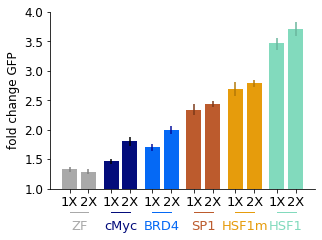

In [24]:
fontsize=13
df=alldfsj
maskcMyc=(df["activator1"]=="cMyc")&(df["name"]=="WT-5") # cMyc here is very off so removing this data. For the first bioRxiv submission it had not been done and hence the difference
df=df[~maskcMyc]
fig=plt.figure(figsize=(4.75,3.25))
ax=fig.add_subplot(111)
af1="ZF(WT)"
TFind=["empty", "cMyc", "BRD4", "SP1", "HSF1m", "HSF1"]
colorsb=["gray","dodgerblue","dodgerblue","orange","orange","purple"]
xlocs=[]
for t,TF in enumerate(TFind):
    TF1=TF
    for t2,TF2 in enumerate(['-',TF1]):
        found=True
        if TF2==TF1:
            af2="ZF(WT)"
        else:
            af2='-'
    
        combi1=df[(df['activator1']==TF1)&(df['activator2']==TF2)&(df['affinity1']==af1)&(df['affinity2']==af2)] #[cGFP]
        combi2=df[(df['activator1']==TF2)&(df['activator2']==TF1)&(df['affinity1']==af2)&(df['affinity2']==af1)] #[cGFP]
        
        if len(combi1)>0 and len(combi2)>0:
            subdf=pd.concat([combi1,combi2])
        elif len(combi1)>0:
            subdf=combi1
        elif len(combi2)>0:
            subdf=combi2
        else:
            found=False
        if not found:
            print("not found")
        else:
            v1=subdf[cGFP].values
            mv1=np.nanmean(v1)
            print(len(v1))
            print(TF1,TF2,v1,mv1,np.min(v1),np.max(v1))
            
            #yerr=[mv1-np.min(v1),np.max(v1)-mv1]
            percentiles=compute_percentiles(v1)
            #print("percentiles", percentiles, mv1)
            #yerr=[mv1-]
            lower=mv1-percentiles[0]
            upper=percentiles[1]-mv1
            #print("mean",mv1)
            #print("lower",lower)
            #print("upper",upper)
            ax.bar(2.2*t+t2,mv1,yerr=np.array([[lower],[upper]]),color=colorsnew[TF],ecolor=colorsnew2[TF],width=0.8)
            xlocs.append(2.2*t+t2)
            #error is the range of the data
            

ax.set_xticks(xlocs)
ax.set_xticklabels(["1X","2X"]*6,fontsize=fontsize)
for i in range(len(TFind)):
    TF=TFind[i]
    if TF=="empty":
        TFtext="ZF"
    else:
        TFtext=TF
    ax.text(2.2*i+0.5,0.3,TFtext,fontsize=fontsize,horizontalalignment='center',color=colorsnew[TF])
# new clear axis overlay with 0-1 limits
for i in range(len(TFind)):
    x,y = np.array([[2.2*i, 2.2*i+1], [0.6,0.6]])
    line = matplotlib.lines.Line2D(x, y, lw=1., color=colorsnew[TFind[i]])
    
    ax.add_line(line)
    line.set_clip_on(False)

    #ax.plot([0.95*2*i,1.05*2*i],[-0.6,-0.6])
    #ax.draw(2*i,-0.6,)
ax.set_ylim(1,4)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel("fold change GFP")
#plt.savefig("figs/singleTF.pdf")
plt.show()
          

In [25]:
markerdict={"WT-WT":"o",
            "WT-5X":"^",
            "5X-WT":"v",
            "WT-7X":">",
            "7X-WT":"<",
            "5X-7X":"*",
            "7X-5X":"X",
            "5X-5X":"D",
            "7X-7X":"s"}
markerdictkorder=["WT-WT","5X-5X","7X-7X","WT-5X","5X-WT","WT-7X","7X-WT","5X-7X","7X-5X"]
colorsdict={'c-S':'yellowgreen', 'c-m':'green', 'c-H':'purple', 'c-B':'blue', 
             'S-m':'orange', 'S-H':'magenta',
            'S-B':'darkolivegreen',  'm-H':'plum', 'm-B':'palegreen', 
            'H-B':'pink', 
            'c-c':'b','c-e':'b', 'S-e':'r','S-S':'r', 'm-m':'orange','m-e':'orange', 'H-H':'purple', 'H-e':'purple', 'B-B':'lightblue','B-e':'lightblue', 'e-e':'grey'}
markers={"SP1":"s","HSF1m":"s","cMyc":"H","BRD4":"H","HSF1":"^"}
#sizes={"SP1":100,"HSF1m":100,"cMyc":100,"BRD4":15,"HSF1":30}
colorsorder=['c-S','m-B','c-m','S-B','m-H','H-B','S-H','c-H','c-B','S-m']
afpat=re.compile(r'\((.+)\)')

In [28]:
dfsyn["SAB"]=pd.to_numeric(dfsyn["SAB"])
dfsyn["SBA"]=pd.to_numeric(dfsyn["SBA"])
dfsyn["fcGFP1"]=pd.to_numeric(dfsyn["fcGFP1"])
dfsyn["fcGFP2"]=pd.to_numeric(dfsyn["fcGFP2"])
dfsyn["fcGFPAB"]=pd.to_numeric(dfsyn["fcGFPAB"])
#maskcMyc=(dfsyn["TF1"]=="cMyc")&(dfsyn["name"]=="WT-5") #it seems cMyc here is very off so removing this data

In [29]:
fontsize=14
green="#c6cdad"
blue="#d3dbe4"
red="#e3cbc8"

cMyc SP1 3
c-S
cMyc HSF1m 2
c-m
cMyc HSF1 3
c-H
cMyc BRD4 3
c-B
SP1 HSF1m 2
S-m
SP1 HSF1 4
S-H
SP1 BRD4 4
S-B
HSF1m HSF1 3
m-H
HSF1m BRD4 2
m-B
HSF1 BRD4 4
H-B


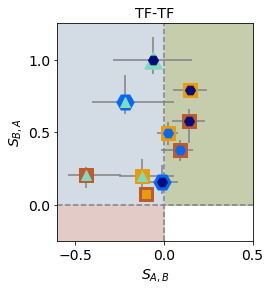

In [30]:
# WT data


af1="ZF(WT)"
af2="ZF(WT)"
fig,ax=plt.subplots(1,1,figsize=(3.5,4))
subdf=dfsyn[(dfsyn["af1"]==af1)&(dfsyn["af2"]==af2)]
maskcMyc=(subdf["TF1"]=="cMyc")&(subdf["name"]=="WT-5")
subdf=subdf[~maskcMyc]
for n1 in range(len(TFnames)-2):
    for n2 in range(n1+1,len(TFnames)-1):
        #TF1,TF2=TFcombi.split('-')
        TF1=TFnames[n1]
        TF2=TFnames[n2]
        data=subdf[(subdf["TF1"]==TF1)&(subdf["TF2"]==TF2)]
        print(TF1,TF2,len(data))
        SABlist=data["SAB"].values
        SBAlist=data["SBA"].values
        mSAB=np.mean(SABlist)
        mSBA=np.mean(SBAlist)
        #error is the range of the data
        xerr=np.array([[mSAB-min(SABlist)],[max(SABlist)-mSAB]])
        yerr=np.array([[mSBA-min(SBAlist)],[max(SBAlist)-mSBA]])
        if TF1!="HSF1m":
            i1=TF1[0]
        else:
            i1="m"
        if TF2!="HSF1m":
            i2=TF2[0]
        else:
            i2="m"
        key="-".join([i1,i2])
        print(key)
        ax.errorbar(mSAB,mSBA,xerr=xerr,yerr=yerr,color="gray",marker='o',ms=1,zorder=2) #,linestyle=':')
        m1=markers[TF1]
        m2=markers[TF2]
        if m1=="s" and m2=="s":
            ax.scatter(mSAB,mSBA,marker=markers[TF1],s=200,color=colorsnew[TF1],zorder=3)
            ax.scatter(mSAB,mSBA,marker=markers[TF2],s=50,color=colorsnew[TF2],zorder=4)
        elif m1=="s" and m2=="H":
            ax.scatter(mSAB,mSBA,marker=markers[TF1],s=200,color=colorsnew[TF1],zorder=3)
            ax.scatter(mSAB,mSBA,marker=markers[TF2],s=100,color=colorsnew[TF2],zorder=4)
        elif m1=="H" and m2=="s":
            ax.scatter(mSAB,mSBA,marker=markers[TF1],s=100,color=colorsnew[TF1],zorder=4)
            ax.scatter(mSAB,mSBA,marker=markers[TF2],s=200,color=colorsnew[TF2],zorder=3)
        elif m1=="s" and m2=="^":
            ax.scatter(mSAB,mSBA,marker=markers[TF1],s=200,color=colorsnew[TF1],zorder=3)
            ax.scatter(mSAB,mSBA,marker=markers[TF2],s=100,color=colorsnew[TF2],zorder=4)
        else:
            ax.scatter(mSAB,mSBA,marker=markers[TF2],s=300,color=colorsnew[TF2],zorder=3)
            ax.scatter(mSAB,mSBA,marker=markers[TF1],s=100,color=colorsnew[TF1],zorder=4)
            
#for key in colorsorder:
#    color=colorsdict[key]
#    ax.scatter(-10,-10,marker='o',color=color,label=key,s=50)
#ax.legend(loc='upper left',bbox_to_anchor=(1.025,1.05),ncol=1)
#ax.legend(loc='upper ')
ax.set_xticks(np.arange(-1,2.5,0.5))
ax.set_yticks(np.arange(-1,2.5,0.5))
ax.set_xlim(-0.6,0.5)
ax.set_ylim(-0.25,1.25)
ax.fill_between([0,1],2,color=green,zorder=1)
ax.fill_between([-1,0],2,color=blue,zorder=1)
ax.fill_between([-1,0],-1,color=red,zorder=1)


ax.set_xlabel(r'$S_{A,B}$',fontsize=fontsize)
ax.set_ylabel(r'$S_{B,A}$',fontsize=fontsize)
ax.tick_params(axis='both',labelsize=fontsize)

#ax.legend(loc=lc,bbox_to_anchor=bbox,ncol=2)
ax.axhline(y=0,linestyle='--',color='grey')
ax.axvline(x=0,linestyle='--',color='grey')
ax.set_title("TF-TF")
#plt.savefig('figs/WT.pdf',bbox_inches='tight')
plt.show()

v1 [1.64027671 1.929     ]
v2 [2.77094543 2.77566667]
e1 cMyc [1.64027671 1.929     ]
e2 HSF1m [2.77094543 2.77566667]
e12 [2.87009992 3.28766667]
error [[0.14436164 0.00236062 0.20878337]
 [0.14436164 0.00236062 0.20878337]]
v1 [2.33973866 2.59033333]
v2 [2.77094543 2.77566667]
e1 SP1 [2.33973866 2.59033333]
e2 HSF1m [2.77094543 2.77566667]
e12 [2.54727133 2.63333333]
error [[0.12529734 0.00236062 0.043031  ]
 [0.12529734 0.00236062 0.043031  ]]
v1 [2.81991814 2.77094543 2.77566667]
v2 [3.31241473 3.81245196 3.31866667]
e1 HSF1m [2.77094543 2.81991814]
e2 HSF1 [3.31241473 3.81245196]
e12 [2.94952251 3.45766667]
error [[0.01789799 0.16876305 0.25102915]
 [0.03107473 0.33127417 0.25711501]]
v1 [1.8170638  2.20366667]
v2 [2.77094543 2.77566667]
e1 BRD4 [1.8170638  2.20366667]
e2 HSF1m [2.77094543 2.77566667]
e12 [2.70253651 2.93366667]
error [[0.19330143 0.00236062 0.11556508]
 [0.19330143 0.00236062 0.11556508]]


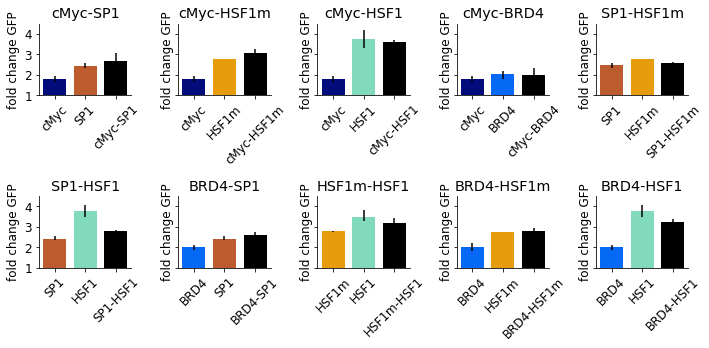

In [31]:
# Now plot barplots for individual TF pairs
mpl.rcParams["font.size"]=12

af1="ZF(WT)"
af2="ZF(WT)"

subdf=dfsyn[(dfsyn["af1"]==af1)&(dfsyn["af2"]==af2)]
maskcMyc=(subdf["TF1"]=="cMyc")&(subdf["name"]=="WT-5")
subdf=subdf[~maskcMyc]
fig,axes=plt.subplots(2,5,figsize=(10,5),sharey=True)
nplot=0
for n1 in range(len(TFnames)-2):
    for n2 in range(n1+1,len(TFnames)-1):
        #TF1,TF2=TFcombi.split('-')
        TF1=TFnames[n1]
        TF2=TFnames[n2]
        data=subdf[(subdf["TF1"]==TF1)&(subdf["TF2"]==TF2)]
        v1=data["fcGFP1"].values
        v2=data["fcGFP2"].values
        v12=data["fcGFPAB"].values
        #print(TF1,TF2,v1,v2)
        #SABlist=data["SAB"].values
        #SBAlist=data["SBA"].values
        
        mv1=np.mean(v1)
        mv2=np.mean(v2)
        mv12=np.mean(v12)
        #print(v12,mv12)
        
        if TF1!="HSF1m":
            i1=TF1[0]
        else:
            i1="m"
        if TF2!="HSF1m":
            i2=TF2[0]
        else:
            i2="m"
        key="-".join([i1,i2])
        
        if mv2<mv1:
            mv1_=mv1
            v1_=v1
            TF1_=TF1
            
            mv1=mv2
            mv2=mv1_
            v1=v2
            v2=v1_
            TF1=TF2
            TF2=TF1_
            
        #error is the range of the data
        #yerr=np.array([[mv1-min(v1),max(v1)-mv1],[mv2-min(v2),max(v2)-mv2],[mv12-min(v12),max(v12)-mv12]]).reshape(2,3)
        
            
        yerr1=compute_percentiles(v1)
        yerr2=compute_percentiles(v2)
        yerr12=compute_percentiles(v12)
        yerr=np.array([[mv1-yerr1[0],mv2-yerr2[0],mv12-yerr12[0]],[yerr1[1]-mv1,yerr2[1]-mv2,yerr12[1]-mv12]])

        
        if TF1=="HSF1m" or TF2=="HSF1m":
            print("v1",v1)
            print("v2",v2)
            print("e1",TF1,yerr1)
            print("e2",TF2,yerr2)
            print("e12",yerr12)
            
            print("error",yerr)
        
        #fig,ax=plt.subplots(1,1,figsize=(3,3))
        ax=axes[nplot//5,nplot%5]
        ax.set_title(TF1+"-"+TF2)
        colors_=[colorsnew[TF1],colorsnew[TF2],"k"]
        patches=ax.bar(range(3),[mv1,mv2,mv12],yerr=yerr,color=colors_,width=0.75) #,color=colorsdict[key],marker='o') #,linestyle=':')
        #for p in range(2):
            #patch=patches[p]
            #patch.set_alpha(0.5)
        ax.set_xticks(range(3))
        ax.set_xticklabels([TF1,TF2,TF1+"-"+TF2],rotation=45)
        ax.set_ylim(1,4.5)
        ax.set_yticks([1,2,3,4])
        ax.set_ylabel("fold change GFP")
        nplot+=1
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
plt.tight_layout()
#plt.savefig("figs/WTdetail.pdf",bbox_inches="tight")
plt.show()


cMyc empty 3
SP1 empty 4
HSF1m empty 2
HSF1 empty 4
BRD4 empty 4


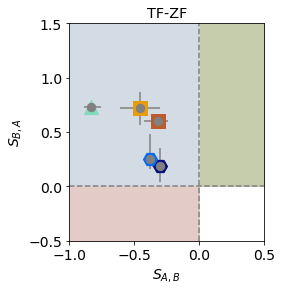

In [32]:
# WT-empty

fontsize=14
af1="ZF(WT)"
af2="ZF(WT)"
fig,ax=plt.subplots(1,1,figsize=(3.5,4))
subdf=dfsyn[(dfsyn["af1"]==af1)&(dfsyn["af2"]==af2)]
maskcMyc=(subdf["TF1"]=="cMyc")&(subdf["name"]=="WT-5")
subdf=subdf[~maskcMyc]
for n1 in range(len(TFnames)-1):
    n2=len(TFnames)-1
    #TF1,TF2=TFcombi.split('-')
    TF1=TFnames[n1]
    TF2=TFnames[n2]
    data=subdf[(subdf["TF1"]==TF1)&(subdf["TF2"]==TF2)]
    print(TF1,TF2,len(data))
    SABlist=data["SAB"].values
    SBAlist=data["SBA"].values
    mSAB=np.mean(SABlist)
    mSBA=np.mean(SBAlist)
    #error is the range of the data
    xerr=np.array([[mSAB-min(SABlist)],[max(SABlist)-mSAB]])
    yerr=np.array([[mSBA-min(SBAlist)],[max(SBAlist)-mSBA]])
    if TF1!="HSF1m":
        i1=TF1[0]
    else:
        i1="m"
    if TF2!="HSF1m":
        i2=TF2[0]
    else:
        i2="m"
    key="-".join([i1,i2])
    ax.errorbar(mSAB,mSBA,xerr=xerr,yerr=yerr,color="gray",marker='o',ms=1,zorder=2) #,linestyle=':')
    m1=markers[TF1]
    m2="o"
    
    ax.scatter(mSAB,mSBA,marker=m1,s=200,color=colorsnew[TF1],zorder=3)
    ax.scatter(mSAB,mSBA,marker=m2,s=70,color="gray",zorder=3)
#for key in colorsorder:
#    color=colorsdict[key]
#    ax.scatter(-10,-10,marker='o',color=color,label=key,s=50)
#ax.legend(loc='upper left',bbox_to_anchor=(1.025,1.05),ncol=1)
#ax.legend(loc='upper ')
ax.set_xticks(np.arange(-1,2.5,0.5))
ax.set_yticks(np.arange(-1,2.5,0.5))
ax.set_xlim(-1,0.5)

ax.set_ylim(-0.5,1.5)


ax.set_xlabel(r'$S_{A,B}$',fontsize=fontsize)
ax.set_ylabel(r'$S_{B,A}$',fontsize=fontsize)
ax.tick_params(axis='both',labelsize=fontsize)

#ax.legend(loc=lc,bbox_to_anchor=bbox,ncol=2)
ax.axhline(y=0,linestyle='--',color='grey')
ax.axvline(x=0,linestyle='--',color='grey')
ax.set_title("TF-ZF")
ax.fill_between([0,1],2,color=green,zorder=1)
ax.fill_between([-1,0],2,color=blue,zorder=1)
ax.fill_between([-1,0],-1,color=red,zorder=1)
#plt.savefig('figs/WT_empty.pdf',bbox_inches='tight')
plt.show()

In [33]:
#check low variability cMyc and HSF1m
subdf=dfsyn[(dfsyn["af1"]=="ZF(WT)")&(dfsyn["af2"]=="ZF(WT)")]
subdf[(subdf["TF1"]=="cMyc")&(subdf["TF2"]=="empty")] #notice that WT-5 is discarded in the plot due to being for WT-5

,TF1,TF2,af1,af2,SAB,SBA,TFA,name,fcGFPAB,fcGFP1,fcGFP2
91,cMyc,empty,ZF(WT),ZF(WT),0.688710,0.064733,cMyc(sw),WT-5,1.368715,0.849162,1.308659
92,cMyc,empty,ZF(WT),ZF(WT),-0.364030,0.045062,cMyc,WT-5-7,1.426483,1.835906,1.382616
93,cMyc,empty,ZF(WT),ZF(WT),-0.250380,0.174153,cMyc,WT-7,1.378939,1.640277,1.222137
94,cMyc,empty,ZF(WT),ZF(WT),-0.295558,0.351683,cMyc,all,1.571667,1.929000,1.231667


cMyc SP1 ZF(WT) ZF(WT) 3 TFA: ['SP1' 'SP1' 'SP1']
SABlist [0.04439412 0.14249287 0.23346239]
SBAlist [0.42584902 0.65490106 0.65874701]
cMyc SP1 ZF(5X) ZF(5X) 2 TFA: ['SP1' 'SP1']
SABlist [-0.01718537  0.3035464 ]
SBAlist [0.59232873 0.85911421]
cMyc SP1 ZF(7X) ZF(7X) 3 TFA: ['SP1' 'SP1' 'SP1']
SABlist [-0.12766505 -0.24005109  0.25434068]
SBAlist [0.68042314 0.95970353 1.03268427]
cMyc HSF1m ZF(WT) ZF(WT) 2 TFA: ['HSF1m' 'HSF1m']
SABlist [0.05072267 0.24422971]
SBAlist [0.80716175 0.76921089]
cMyc HSF1m ZF(5X) ZF(5X) 1 TFA: ['HSF1m']
SABlist [0.40816642]
SBAlist [0.98197606]
cMyc HSF1m ZF(7X) ZF(7X) 2 TFA: ['HSF1m' 'HSF1m']
SABlist [-0.23351204  0.2948929 ]
SBAlist [0.8585171  0.96743279]
cMyc HSF1 ZF(WT) ZF(WT) 3 TFA: ['HSF1' 'HSF1' 'HSF1']
SABlist [-0.2836463  -0.05998485  0.15679156]
SBAlist [0.89955209 1.1567951  0.93954215]
cMyc HSF1 ZF(5X) ZF(5X) 2 TFA: ['HSF1' 'HSF1']
SABlist [-0.15691711 -0.02856438]
SBAlist [0.84828649 0.8973515 ]
cMyc HSF1 ZF(7X) ZF(7X) 3 TFA: ['HSF1' 'HSF1'

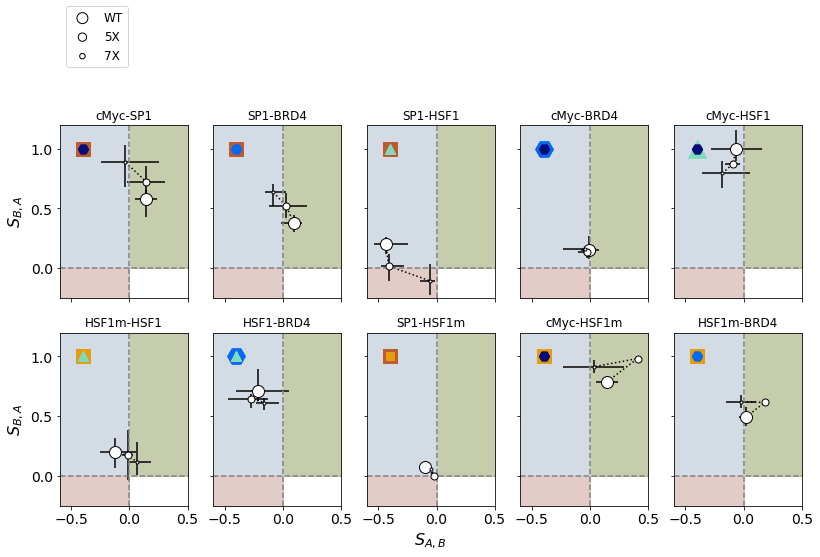

In [34]:
axdict={"c-S":(0,0),"S-B":(0,1),"c-H":(0,4),"c-B":(0,3),"S-H":(0,2),
       "m-H":(1,0),"H-B":(1,1),"S-m":(1,2),"c-m":(1,3),"m-B":(1,4)}
fig,axes=plt.subplots(2,5,figsize=(13.3,7),sharex=True,sharey=True)
#axes=[axes[0][0],axes[0][1],axes[1][0],axes[1][1]]
#subdf=dfsyn[(dfsyn["af1"]==af1)&(dfsyn["af2"]==af2)]
maskcMyc=(dfsyn["TF1"]=="cMyc")&(dfsyn["name"]=="WT-5")
subdf=dfsyn[~maskcMyc]

msWT=12
ms5=7
ms7=3
for n1 in range(len(TFnames)-2):
    for n2 in range(n1+1,len(TFnames)-1):
        mSABvals=[]
        mSBAvals=[]
        allxerr=[]
        allyerr=[]
        for af1 in affinities:
            for af2 in affinities:
                if af1==af2:
                    #print(af1)
                    #TF1,TF2=TFcombi.split('-')
                    TF1=TFnames[n1]
                    TF2=TFnames[n2]
                    data=subdf[(subdf["TF1"]==TF1)&(subdf["TF2"]==TF2)&(subdf["af1"]==af1)&(subdf["af2"]==af2)]
                    
                    print(TF1,TF2,af1,af2,len(data), "TFA:", data["TFA"].values)
                    SABlist=data["SAB"].values
                    SBAlist=data["SBA"].values
                    print("SABlist",SABlist)
                    print("SBAlist",SBAlist)
                    mSAB=np.mean(SABlist)
                    mSBA=np.mean(SBAlist)
                    #error is the range of the data
                    xerr=np.array([[mSAB-min(SABlist)],[max(SABlist)-mSAB]])
                    yerr=np.array([[mSBA-min(SBAlist)],[max(SBAlist)-mSBA]])
                    if TF1!="HSF1m":
                        i1=TF1[0]
                    else:
                        i1="m"
                    if TF2!="HSF1m":
                        i2=TF2[0]
                    else:
                        i2="m"
                    
                    key="-".join([i1,i2])
                    c0,c1=axdict[key]
                    ax=axes[c0,c1]
                    

                    #if i1=="H" or i2=="H":
                    #    ax=axes[1]
                    #elif key=="c-B" or key=="S-m":
                    #    ax=axes[2]
                    #else:
                    #    ax=axes[0]
                    if "WT" in af1:
                        ms=msWT
                    elif "5" in af1:
                        ms=ms5
                    else:
                        ms=ms7
                    mSABvals.append(mSAB)
                    mSBAvals.append(mSBA)
                    allxerr.append(xerr)
                    allyerr.append(yerr)
                
                    #ax.scatter(mSAB,mSBA,color=colorsdict[key],marker='o',s=20*ms)
                    if "WT" in af1:
                        label=key
                    else:
                        label=""
                    ax.errorbar(mSAB,mSBA,xerr=xerr,yerr=yerr,color="k",marker='o',ms=ms,markerfacecolor='w') #,fillstyle='none')
                    ax.set_title("%s-%s"%(TF1,TF2),fontsize=12)
                    #ax.text(-0.4,1.3,TF1,color=colorsnew[TF1],verticalalignment="center")
                    #ax.text(0,1.3,"-")
                    #ax.text(0.05,1.3,TF2,color=colorsnew[TF2],verticalalignment="center")
                    
                    m1=markers[TF1]
                    m2=markers[TF2]
                    if m1=="s" and m2=="s":
                        ax.scatter(-0.4,1,marker=markers[TF1],s=200,color=colorsnew[TF1],zorder=3)
                        ax.scatter(-0.4,1,marker=markers[TF2],s=50,color=colorsnew[TF2],zorder=4)
                    elif m1=="s" and m2=="H":
                        ax.scatter(-0.4,1,marker=markers[TF1],s=200,color=colorsnew[TF1],zorder=3)
                        ax.scatter(-0.4,1,marker=markers[TF2],s=100,color=colorsnew[TF2],zorder=4)
                    elif m1=="H" and m2=="s":
                        ax.scatter(-0.4,1,marker=markers[TF1],s=100,color=colorsnew[TF1],zorder=4)
                        ax.scatter(-0.4,1,marker=markers[TF2],s=200,color=colorsnew[TF2],zorder=3)
                    elif m1=="s" and m2=="^":
                        ax.scatter(-0.4,1,marker=markers[TF1],s=200,color=colorsnew[TF1],zorder=3)
                        ax.scatter(-0.4,1,marker=markers[TF2],s=100,color=colorsnew[TF2],zorder=4)
                    else:
                        ax.scatter(-0.4,1,marker=markers[TF2],s=300,color=colorsnew[TF2],zorder=3)
                        ax.scatter(-0.4,1,marker=markers[TF1],s=100,color=colorsnew[TF1],zorder=4)
                    
        ax.plot(mSABvals,mSBAvals,linestyle=':',color="k")
#for key in colorsorder:
#    color=colorsdict[key]
#    ax.scatter(-10,-10,marker='o',color=color,label=key,s=50)
#ax.legend(loc='upper left',bbox_to_anchor=(1.025,1.05),ncol=1)
#ax.legend(loc='upper ')
for row in axes:
    for ax in row:
        ax.set_xticks(np.arange(-1,2.5,0.5))
        ax.set_yticks(np.arange(-1,2.5,0.5))
        ax.set_xlim(-0.6,0.5)

        ax.set_ylim(-0.25,1.2)
        #for ms in [[msWT,"WT"],[ms5,"5X"],[ms7,"7X"]]:
        #    ax.scatter(-10,-10,marker='o',s=10*ms[0],label=ms[1],color='k',facecolor='none')
            # get handles
        #handles, labels = ax.get_legend_handles_labels()
        #print(handles)
        # remove the errorbars
        #handles = [handles[i][0] if i>2 else handles[i] for i in range(len(handles))]
        # use them in the legend
        #ax.legend( loc='upper left',numpoints=1)


        #ax.legend(handles, labels, loc='upper left',bbox_to_anchor=(1,1),ncol=1,numpoints=1)


        
        ax.tick_params(axis='both',labelsize=fontsize)

        #ax.legend(loc=lc,bbox_to_anchor=bbox,ncol=2)
        ax.axhline(y=0,linestyle='--',color='grey')
        ax.axvline(x=0,linestyle='--',color='grey')
        
        ax.fill_between([0,1],2,color=green,zorder=1)
        ax.fill_between([-1,0],2,color=blue,zorder=1)
        ax.fill_between([-1,0],-1,color=red,zorder=1)
ax=axes[0,0]
ax.set_ylabel(r'$S_{B,A}$',fontsize=16)
ax=axes[1,0]
ax.set_ylabel(r'$S_{B,A}$',fontsize=16)
ax=axes[1,2]
ax.set_xlabel(r'$S_{A,B}$',fontsize=16)

ax=axes[0,0]
for ms in [[msWT,"WT"],[ms5,"5X"],[ms7,"7X"]]:
    ax.scatter(-10,-10,marker='o',s=10*ms[0],label=ms[1],color='k',facecolor='none')
    # get handles
handles, labels = ax.get_legend_handles_labels()
#print(handles)
# remove the errorbars
handles = [handles[i][0] if i>2 else handles[i] for i in range(len(handles))]
# use them in the legend
ax.legend(handles,labels, loc='lower left',bbox_to_anchor=(0,1.3),numpoints=1,ncol=1)
#fig.text(0,0.5,"more affinity, more synergy")
#fig.text(0,0.15,"more affinity, less synergy")
#ax.scatter(-5,-5)
#plt.tight_layout()
#plt.savefig('figs/affinity.pdf',bbox_inches='tight')
plt.show()

----------------------
cMyc SP1
cMyc SP1 ZF(WT) ZF(WT) 3 TFA ['SP1']
cMyc SP1 ZF(WT) ZF(5X) 2 TFA ['SP1']
cMyc SP1 ZF(WT) ZF(7X) 2 TFA ['SP1']
cMyc SP1 ZF(5X) ZF(WT) 2 TFA ['SP1']
cMyc SP1 ZF(5X) ZF(7X) 1 TFA ['SP1']
af1 ZF(5X) af2 ZF(7X) should be 5-7
cMyc SP1 ZF(7X) ZF(WT) 2 TFA ['SP1']
cMyc SP1 ZF(7X) ZF(5X) 1 TFA ['SP1']
af1 ZF(7X) af2 ZF(5X) should be 5-7
----------------------
cMyc HSF1m
cMyc HSF1m ZF(WT) ZF(WT) 2 TFA ['HSF1m']
cMyc HSF1m ZF(WT) ZF(5X) 1 TFA ['HSF1m']
cMyc HSF1m ZF(WT) ZF(7X) 1 TFA ['HSF1m']
cMyc HSF1m ZF(5X) ZF(WT) 1 TFA ['HSF1m']
cMyc HSF1m ZF(5X) ZF(7X) 1 TFA ['HSF1m']
af1 ZF(5X) af2 ZF(7X) should be 5-7
cMyc HSF1m ZF(7X) ZF(WT) 1 TFA ['HSF1m']
cMyc HSF1m ZF(7X) ZF(5X) 1 TFA ['HSF1m']
af1 ZF(7X) af2 ZF(5X) should be 5-7
----------------------
cMyc HSF1
cMyc HSF1 ZF(WT) ZF(WT) 3 TFA ['HSF1']
cMyc HSF1 ZF(WT) ZF(5X) 2 TFA ['HSF1']
cMyc HSF1 ZF(WT) ZF(7X) 2 TFA ['HSF1']
cMyc HSF1 ZF(5X) ZF(WT) 2 TFA ['HSF1']
cMyc HSF1 ZF(5X) ZF(7X) 1 TFA ['HSF1']
af1 ZF(5X) af2 Z

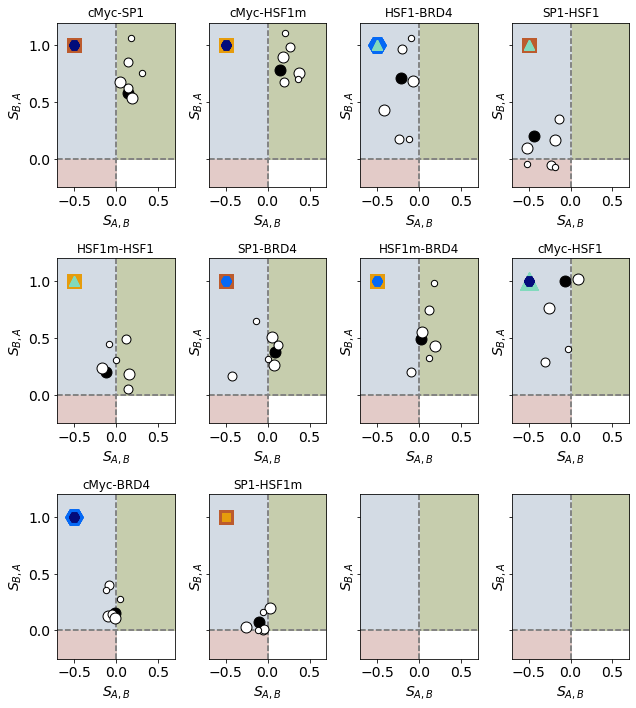

In [35]:
#different AD, WT-WT and different affinity
axdict={"c-S":(0,0),"S-B":(1,1),"c-H":(1,3),"c-B":(2,0),"S-H":(0,3),
       "m-H":(1,0),"H-B":(0,2),"S-m":(2,1),"c-m":(0,1),"m-B":(1,2)}
fig,axes=plt.subplots(3,4,figsize=(9,10),sharex=True,sharey=True)
#subdf=dfsyn[(dfsyn["af1"]==af1)&(dfsyn["af2"]==af2)]
subdf=dfsyn[~maskcMyc]

msWT=12
msWT5=12
msWT7=8
ms57=4
for n1 in range(len(TFnames)-2):
    for n2 in range(n1+1,len(TFnames)-1):
        
        TF1=TFnames[n1]
        TF2=TFnames[n2]
        print("----------------------")
        print(TF1,TF2)
        mSABvals=[]
        mSBAvals=[]
        allxerr=[]
        allyerr=[]
        for af1 in affinities:
            for af2 in affinities:
                if af1!=af2 or ("WT" in af1 and "WT" in af2):
                    #print(af1)
                    #TF1,TF2=TFcombi.split('-')
                    data=subdf[(subdf["TF1"]==TF1)&(subdf["TF2"]==TF2)&(subdf["af1"]==af1)&(subdf["af2"]==af2)]

                    print(TF1,TF2,af1,af2,len(data), "TFA", data["TFA"].unique())
                    
                    SABlist=data["SAB"].values
                    SBAlist=data["SBA"].values
                    mSAB=np.mean(SABlist)
                    mSBA=np.mean(SBAlist)
                    #error is the range of the data
                    xerr=np.array([[mSAB-min(SABlist)],[max(SABlist)-mSAB]])
                    yerr=np.array([[mSBA-min(SBAlist)],[max(SBAlist)-mSBA]])
                    if TF1!="HSF1m":
                        i1=TF1[0]
                    else:
                        i1="m"
                    if TF2!="HSF1m":
                        i2=TF2[0]
                    else:
                        i2="m"

                    key="-".join([i1,i2])
                    key="-".join([i1,i2])
                    c0,c1=axdict[key]
                    ax=axes[c0,c1]
                    
                    WTaf=af5=af7=False
                    if "WT" in af1 and "WT" in af2:
                        label=""
                        ms=msWT
                        facecolor="k"
                    else:
                        facecolor="w"
                        label=""
                        if "WT" in af1 or "WT" in af2:
                            WTaf=True
                            
                        if "5" in af1 or "5" in af2:
                            af5=True
                        if "7" in af1 or "7" in af2:
                            af7=True
                        if WTaf and af5:
                            ms=msWT5
                        elif WTaf and af7:
                            ms=msWT7
                        else:
                            print("af1", af1, "af2", af2, "should be 5-7")
                            ms=ms57
                    
                    ax.scatter(mSAB,mSBA,marker='o',s=ms*10,edgecolors="k",c=facecolor,zorder=5) #,fillstyle='none')

                    #ax.errorbar(mSAB,mSBA,xerr=xerr,yerr=yerr,color="k",marker='o',ms=ms,markerfacecolor=facecolor) #,fillstyle='none')
                    ax.set_title("%s-%s"%(TF1,TF2),fontsize=12)
                    #ax.text(-0.4,1.3,TF1,color=colorsnew[TF1],verticalalignment="center")
                    #ax.text(0,1.3,"-")
                    #ax.text(0.05,1.3,TF2,color=colorsnew[TF2],verticalalignment="center")
                    
                    m1=markers[TF1]
                    m2=markers[TF2]
                    xcoord=-0.5
                    if m1=="s" and m2=="s":
                        ax.scatter(xcoord,1,marker=markers[TF1],s=200,color=colorsnew[TF1],zorder=3)
                        ax.scatter(xcoord,1,marker=markers[TF2],s=50,color=colorsnew[TF2],zorder=4)
                    elif m1=="s" and m2=="H":
                        ax.scatter(xcoord,1,marker=markers[TF1],s=200,color=colorsnew[TF1],zorder=3)
                        ax.scatter(xcoord,1,marker=markers[TF2],s=100,color=colorsnew[TF2],zorder=4)
                    elif m1=="H" and m2=="s":
                        ax.scatter(xcoord,1,marker=markers[TF1],s=100,color=colorsnew[TF1],zorder=4)
                        ax.scatter(xcoord,1,marker=markers[TF2],s=200,color=colorsnew[TF2],zorder=3)
                    elif m1=="s" and m2=="^":
                        ax.scatter(xcoord,1,marker=markers[TF1],s=200,color=colorsnew[TF1],zorder=3)
                        ax.scatter(xcoord,1,marker=markers[TF2],s=100,color=colorsnew[TF2],zorder=4)
                    else:
                        ax.scatter(xcoord,1,marker=markers[TF2],s=300,color=colorsnew[TF2],zorder=3)
                        ax.scatter(xcoord,1,marker=markers[TF1],s=100,color=colorsnew[TF1],zorder=4)


                    
for row in axes:
    for ax in row:
        ax.set_xticks(np.arange(-0.5,2.5,0.5))
        ax.set_yticks(np.arange(-1,2.5,0.5))
        ax.set_xlim(-0.7,0.7)

        ax.set_ylim(-0.25,1.2)
        
        #ax.tick_params(axis='both',labelsize=fontsize)
        ax.xaxis.set_tick_params(which='both', labelbottom=True)

        #ax.legend(loc=lc,bbox_to_anchor=bbox,ncol=2)
        ax.axhline(y=0,linestyle='--',color='grey')
        ax.axvline(x=0,linestyle='--',color='grey')
        
        ax.fill_between([0,1],2,color=green,zorder=1)
        ax.fill_between([-1,0],2,color=blue,zorder=1)
        ax.fill_between([-1,0],-1,color=red,zorder=1)


        ax.set_xlabel(r'$S_{A,B}$',fontsize=fontsize)
        ax.set_ylabel(r'$S_{B,A}$',fontsize=fontsize)
        ax.tick_params(axis='both',labelsize=fontsize)

        #ax.legend(loc=lc,bbox_to_anchor=bbox,ncol=2)
        ax.axhline(y=0,linestyle='--',color='grey')
        ax.axvline(x=0,linestyle='--',color='grey')
ax=axes[0,0]
ax.scatter(-10,-10,marker='o',s=10*msWT,label="WT-WT",color='k',facecolor='k')
for ms in [[msWT5,"WT-5X"],[msWT7,"WT-7X"],[ms57,"5X-7X"],]:
    ax.scatter(-10,-10,marker='o',s=10*ms[0],label=ms[1],color='k',facecolor='none')



# get handles
#handles, labels = ax.get_legend_handles_labels()
#print(handles)
# remove the errorbars
#handles = [handles[i] for i in range(len(handles))]
# use them in the legend
#ax.legend(handles,labels, loc='lower left',bbox_to_anchor=(0,1.3),numpoints=1,ncol=4)
#ax=axes[0]    
#ax.set_title("more affinity-more synergy",fontsize=fontsize)
#ax=axes[1]
#ax.set_title("nonmonotonic or \n more affinity-less synergy",fontsize=fontsize)
#ax=axes[2]
#ax.set_title("")
#ax=axes[2]
#ax.set_ylim(-0.1,0.3)
#ax.set_xlim(-0.2,0.2)
plt.tight_layout() #w_pad=15,h_pad=5)
#plt.savefig('figs/crossaffinity.pdf',bbox_inches='tight')
plt.show()

In [36]:
affinities

['ZF(WT)', 'ZF(5X)', 'ZF(7X)']

In [38]:
mpl.rcParams["font.size"]=12

         ['Hm' 'WT-5' 'WT-5-7' 'WT-7' 'all']
ZF(WT) [3.31241473 3.89385475 4.16896832 3.81245196 3.31866667]
         ['Hm' 'WT-5' 'WT-5-7' 'all']
ZF(5X) [3.37517053 4.30307263 3.61007311 4.02966667]
         ['Hm' 'WT-5-7' 'WT-7' 'all']
ZF(7X) [2.40654843 2.78635256 2.84089162 2.872     ]


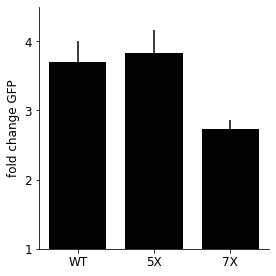

In [39]:
subdf=dfsyn[(dfsyn["TF1"]=="HSF1")&(dfsyn["TF2"]=="HSF1")]
fig,ax=plt.subplots(1,1,figsize=(4,4))

for a,af1 in enumerate(affinities):
    data=subdf[(subdf["af1"]==af1)&(subdf["af2"]==af1)]
    
    v1=data["fcGFP1"].values
    print("        ", data.name.values)
    print(af1,v1)
    

    #print(TF1,TF2,v1,v2)
    #SABlist=data["SAB"].values
    #SBAlist=data["SBA"].values

    mv1=np.mean(v1)
    
    yerr1=compute_percentiles(v1)
       
    yerr=np.array([[mv1-yerr1[0]],[yerr1[1]-mv1]])

        
    patches=ax.bar(a,[mv1],yerr=yerr,color="k",width=0.75) #,color=colorsdict[key],marker='o') #,linestyle=':')
        
ax.set_xticks(range(3))
ax.set_xticklabels(["WT","5X","7X"])
ax.set_ylim(1,4.5)
ax.set_yticks([1,2,3,4])
ax.set_ylabel("fold change GFP")
nplot+=1
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
#plt.savefig("figs/HSF1affinity.pdf",bbox_inches="tight")
plt.show()